In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from glob import glob
from tqdm import tqdm
import numba as nb
import spect

In [ ]:
import imp
imp.reload(spect)

In [4]:
df = pd.read_csv("../data/metadata.csv")
df

,sample_id,split,instrument_type,features_path,features_md5_hash
0,S0000,train,commercial,train_features/S0000.csv,017b9a71a702e81a828e6242aa15f049
1,S0001,train,commercial,train_features/S0001.csv,0d09840214054d254bd49436c6a6f315
2,S0002,train,commercial,train_features/S0002.csv,3f58b3c9b001bfed6ed4e4f757083e09
3,S0003,train,commercial,train_features/S0003.csv,e9a12f96114a2fda60b36f4c0f513fb1
4,S0004,train,commercial,train_features/S0004.csv,b67603d3931897bfa796ac42cc16de78
...,...,...,...,...,...
1565,S1565,test,sam_testbed,test_features/S1565.csv,3146a38af69bb12aff54b9cd1e2c49e8
1566,S1566,test,sam_testbed,test_features/S1566.csv,239d0687ec42966d80394c7b206c23df
1567,S1567,test,sam_testbed,test_features/S1567.csv,040585537a39523a582af874ff2f3b3d
1568,S1568,test,sam_testbed,test_features/S1568.csv,6211107e4f0eedcdc5750cd27f57d4fa


In [9]:
df = pd.read_csv("../data/supplemental_metadata.csv")
df

,sample_id,split,instrument_type,carrier_gas,different_pressure,features_path,features_md5_hash
0,X0000,supplemental,commercial,he,0,supplemental_features/X0000.csv,415d9be2aaa9151551ec2ce94aac3236
1,X0001,supplemental,commercial,he,0,supplemental_features/X0001.csv,4d0fb1f6f9b970c2a21280b64e146148
2,X0002,supplemental,commercial,he,0,supplemental_features/X0002.csv,4d8b44276eea5291de30f6764f67a5d3
3,X0003,supplemental,commercial,he,0,supplemental_features/X0003.csv,6c21bb6c254f38734ec7d9afd5146099
4,X0004,supplemental,commercial,he,0,supplemental_features/X0004.csv,b8c549be189f6cb14f6afa60d9b9b105
...,...,...,...,...,...,...,...
383,X0383,supplemental,sam_testbed,he,0,supplemental_features/X0383.csv,7c1e83ca018ced016038c5af3874329e
384,X0384,supplemental,sam_testbed,he,0,supplemental_features/X0384.csv,bbe41531e4525a3f7e0c4ec0f810fa87
385,X0385,supplemental,sam_testbed,he,0,supplemental_features/X0385.csv,dffed7b0955bcc419644ac2d90597723
386,X0386,supplemental,sam_testbed,he,0,supplemental_features/X0386.csv,a4db0c66658c5d6c464492d860abb9d0


In [12]:
df.groupby(['carrier_gas', 'different_pressure']).count()

sample_id  split  instrument_type  \
carrier_gas different_pressure                                      
he          0                         261    261              261   
            1                          10     10               10   
n2          1                          19     19               19   
o2          0                           1      1                1   
            1                          97     97               97   

                                features_path  features_md5_hash  
carrier_gas different_pressure                                    
he          0                             261                261  
            1                              10                 10  
n2          1                              19                 19  
o2          0                               1                  1  
            1                              97                 97

In [49]:
ds_bin = spect.get_binned_data()
ds_sup = spect.supplementary_get_binned_data()

 98%|███████████████████████████████████████████████████████████████████████████████▎ | 380/388 [01:07<00:03,  2.37it/s]/exports/csce/datastore/geos/users/s1205782/Projects/spect/notebooks/spect.py:178: UserWarning: Problem with file: ../data/supplemental_features/X0380.csv
  return ds_regrid
100%|█████████████████████████████████████████████████████████████████████████████████| 388/388 [01:11<00:00,  5.41it/s]


In [50]:
ds_sup.instrument_type.groupby(ds_sup.instrument_type).count()

<xarray.DataArray 'instrument_type' (instrument_type: 2)>
array([220,  41])
Coordinates:
  * instrument_type  (instrument_type) object 'commercial' 'sam_testbed'

In [37]:
ds_scale = ds_bin['abundance'].mean(dim=('temp_bins', 'mz')).groupby(ds_bin.instrument_type).mean()
missing_fill = np.nan

def preprocess(ds, drop_he=False, rebase=False, maxscale=True, scale_int=True, log_scale=False, nan_fill=missing_fill):
    ds_pro = ds.copy(deep=True)
    ds_pro['features'] = ds_pro['abundance'].clip(0, None)
    ds_pro['integrated_abundance'] = ds_pro['features'].mean(dim='temp_bins')
    if scale_int:
        ds_pro['integrated_abundance'] = (
            (ds_pro['integrated_abundance'].groupby(ds.instrument_type)/ds_scale)
            .drop('instrument_type')
        )
    if rebase:
        ds_pro['features'] = ds_pro.features - ds_pro.features.min(dim=('temp_bins'))
    if drop_he:
        ds_pro = ds_pro.drop_sel(mz=4)
    if maxscale:
        ds_pro['features'] = ds_pro.features/ds_pro.features.max(dim=('temp_bins', 'mz'))
    if log_scale:
        ds_pro['features'] = np.log10(ds_pro['features'].clip(1e-4,None))+3
        ds_pro['integrated_abundance'] = np.log10(ds_pro['integrated_abundance'].clip(1e-4,None))+3
    ds_pro = ds_pro.fillna(nan_fill)
    return ds_pro

In [63]:
ds_bin = preprocess(ds_bin, log_scale=True)
ds_sup = preprocess(ds_sup, log_scale=True)

In [64]:
ds_bin

<xarray.Dataset>
Dimensions:               (sample_id: 1570, temp_bins: 21, mz: 81, species: 10)
Coordinates:
  * sample_id             (sample_id) object 'S0000' 'S0001' ... 'S1568' 'S1569'
  * mz                    (mz) int64 0 1 2 3 4 5 6 7 ... 73 74 75 76 77 78 79 80
  * temp_bins             (temp_bins) object (0, 50] (50, 100] ... (1000, 1050]
  * species               (species) <U14 'basalt' 'carbonate' ... 'sulfide'
Data variables:
    abundance             (sample_id, temp_bins, mz) float64 5.543e-11 ... 270.4
    time                  (sample_id, temp_bins) float64 61.56 ... 1.633e+03
    temp                  (sample_id, temp_bins) float64 40.9 74.9 ... 1.029e+03
    labels                (sample_id, species) float64 0.0 0.0 0.0 ... nan nan
    split                 (sample_id) object 'train' 'train' ... 'test' 'test'
    instrument_type       (sample_id) object 'commercial' ... 'sam_testbed'
    features              (sample_id, temp_bins, mz) float64 0.5044 ... -0.1903
    integrated_abundance  (sample_id, mz) float64 -1.0 -1.0 -1.0 ... nan 0.7534

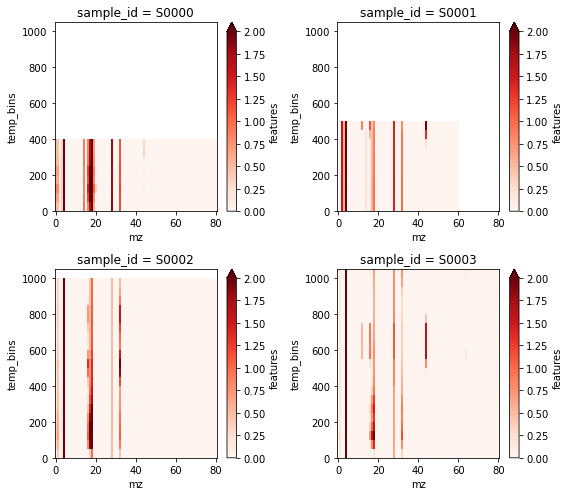

In [65]:
fig, axes = plt.subplots(2,2,figsize=(8,7)) 

i=0
indexes = [0,1,2,3,]
for ax in axes.flatten():
    ds_bin.features.isel(sample_id=indexes[i]).clip(0, None).plot(ax=ax, vmin=0, vmax=2, cmap='Reds')
    i+=1
plt.tight_layout()
plt.show()

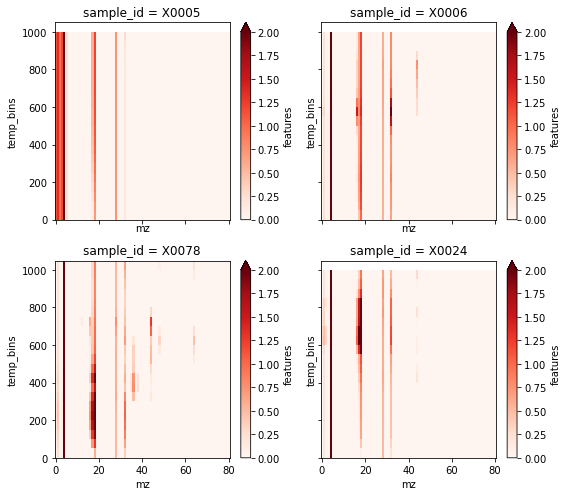

In [66]:
fig, axes = plt.subplots(2,2,figsize=(8,7), sharex=True, sharey=True) 

i=0
indexes = [5,6,78,24]
for ax in axes.flatten():
    ds_sup.features.isel(sample_id=indexes[i]).clip(0, None).plot(ax=ax, vmin=0, vmax=2, cmap='Reds')
    i+=1
plt.tight_layout()
plt.show()

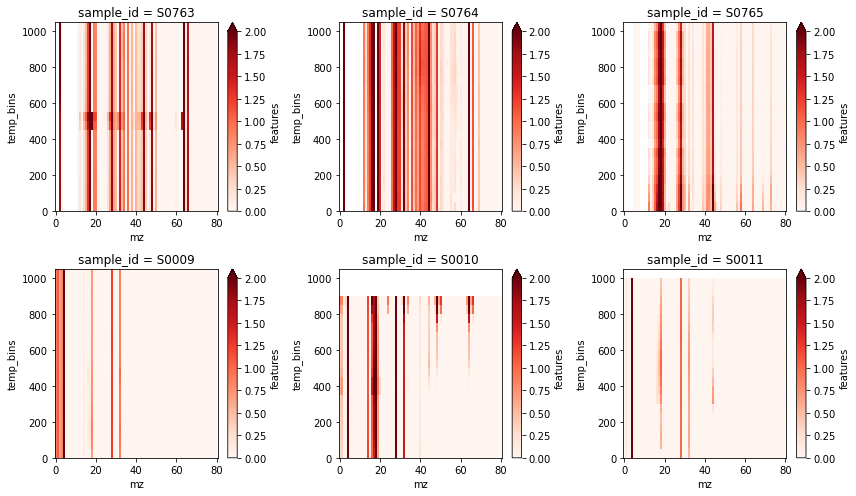

In [72]:
fig, axes = plt.subplots(2,3,figsize=(12,7)) 

i=0
n0 = 9
indexes = (
    list(ds_bin.where(ds_bin.instrument_type=='sam_testbed', drop=True).sample_id[n0:n0+3].values) +
    list(ds_bin.where(ds_bin.instrument_type=='commercial', drop=True).sample_id[n0:n0+3].values)
)
for ax in axes.flatten():
    ds_bin.features.sel(sample_id=indexes[i]).clip(0, None).plot(ax=ax, vmin=0, vmax=2, cmap='Reds')
    i+=1
plt.tight_layout()
plt.show()

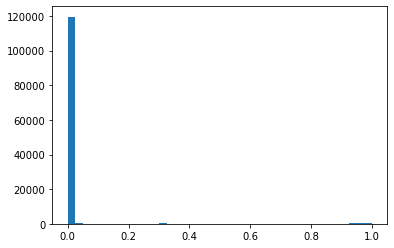

In [89]:
plt.hist(preprocess(ds_bin).min(dim='temp_bins').features.values.flatten(), bins=40)
plt.show()

Based on thr above, I don't think I need to worry about rebasing each of the curves to zero